# End-to-end Multi-class dog breed identification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow hub.

## 1.Problem
Identifying the breed of a dog given an image of a dog.

When I'm sitting at a cafe and I take a photo of a dog, I want to know what breed of dog it is.

## 2.Data
The data we're using is from Kaggle's dog breed identification competition.

https://www.kaggle.com/c/dog-breed-identification

## 3.Evaluation
The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification

## 4. Features
Some information about the data.
* We're dealing with the image (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10000+ images in the training set (these images have labels).
* There are aound 10000+ images in the test set (these images have no labels).

### Get our workspace ready
* Import TensorFlow 2.x
* Import TensorFlow Hub
* Make sure we're using a GPU

In [1]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

# Check for GPU availability
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "NOT available")

TF version: 2.10.0
TF Hub version: 0.8.0
GPU NOT available


## Getting our data ready (turning into tensors)

With all machine learning models, our data has to be in numerical format.  So that's what we're doing first.  Turning our images into Tensors (numerical representations).

Let's start by accessing our data and checking out labels.

In [2]:
# Checkout the labels of our data

import pandas as pd
labels_csv = pd.read_csv("data/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


### Getting images and their labels

Let's get a list of all our images file pathnames.

In [3]:
# Create pathnames of images ID :
filenames = ["data/train/"+fname+".jpg" for fname in labels_csv["id"]]

# Check the first 10
filenames[:10]

['data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'data/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'data/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'data/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'data/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'data/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'data/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [4]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir("data/train/")) == len(filenames):
  print("Filenames matches actual amount of files.  Procceed")
else:
  print("Filenames do not macht the actual amount of files.  Check the target directory.")

Filenames matches actual amount of files.  Procceed


Since we've now got our training page filepath in the list, let's prepare our labels.

In [5]:
import numpy as np
labels = labels_csv["breed"]
labels = np.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [6]:
# Find the unique label values
unique_breeds = np.unique(labels)
unique_breeds, len(unique_breeds)

(array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
        'american_staffordshire_terrier', 'appenzeller',
        'australian_terrier', 'basenji', 'basset', 'beagle',
        'bedlington_terrier', 'bernese_mountain_dog',
        'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
        'bluetick', 'border_collie', 'border_terrier', 'borzoi',
        'boston_bull', 'bouvier_des_flandres', 'boxer',
        'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
        'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
        'chow', 'clumber', 'cocker_spaniel', 'collie',
        'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
        'doberman', 'english_foxhound', 'english_setter',
        'english_springer', 'entlebucher', 'eskimo_dog',
        'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
        'german_short-haired_pointer', 'giant_schnauzer',
        'golden_retriever', 'gordon_setter', 'gre

### Creating our own validation set
Since the dataet from Kaggle doesn't come with a valiation set, we're going to creating our own.

We're going to start off experimenting with approx 1000 images and increase as needed.

In [7]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [8]:
# Let's split our data into train and validation
from sklearn.model_selection import train_test_split


## Preprocessing images (turning images into Tensors)

To preprocess ourb images into Tensors we're going to write a function which does a few things:
1. Take an image filepath as input
2. Use TensorFLow to read the file and save it to a variable 'image'
3. Turn our 'image' into Tensors
4. Normalise our image (convert colours channel values from 0-255 to 0-1)
5. Resize the 'image' to be a shape of (224, 224)
6. Return the modified image

Before we do, let's see what importing an image looks like.

In [9]:
# Convert an image to a NumPy array
from matplotlib.pyplot import imread

image = imread(filenames[42])
image.shape

(257, 350, 3)

In [10]:
# Turn image into a tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

In [11]:
# Define image size
IMG_SIZE=224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path an turn it into a Tensor
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turns the jpeg image into numerical Tensor with 3 colour channels (RGB)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-255 to 0-1
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224,224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

## Turning our data into batches

Why turn our data into batches?

Let's say you're trying to process 10000+ in one go... they all might not fit into memory.

So that's why we do about 32 images (batch size) at a time (you can manually adjust the batch size if need be)

In order to use TensorFlow effectively, we need our data in the forst of Tensor tupels which look like this: '(image, label)'

In [12]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label, processes the images and returns a tuple of (image, label)
  """
  image = process_image(image_path)
  return image, label

Now we've got a way to turn our data into tuples of Tensors in the form (image, label), let's make a function to turn all of our data (X & y) into batches

In [13]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data if a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    # If the data is a training dataset, we shuffle it
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels

    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

## Visualising data batches

Our data is now in batches, however, these can be a little hard to understand/comprehend, let's visualise them!

## Building a model

Before we build a model, there are a few things we need to define:
* The input shape (our image shape, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) to our model
* The URL of the model we want to use FROM TensorFlow Hub : https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

In [14]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

Now we've got our inputs, outputs and model ready to go.
Let's put them together into a Keras deep learning model!

Knowing this, let's create a function which:
* Takes the input shape, the output shape and the model we've chosen as parameters.
* Defines the layers in a Keras model in a sequential fashion (do this, then this, then that)
* Compiles the model (says how it should be evaluated and improved)
* Builds the model (tells the model the input shape it'll be getting)
* Returns the model

All these steps can be found here : https://www.tensorflow.org/guide/keras?hl=fr

## Training a model

Our first model is only going to train on 1000 images, to make sure everything is working.

In [15]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [16]:

# Check to make sure we're still running on GPU
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "NOT available")

GPU NOT available


Let's create a function which trains a model

* Create a model using "create_model()"
* Setup a TensorBoard callback using "create_tensorboard_callback()"
* Call the "fit()" function on our model passing it the training data, the validation data, number of epochs to train for (NUM_EPOCHS) and the callbacks we'd like to use
* Return the model

Having the above functionality is great but we want to be able to do it at scale

And it would be even better if we could see the image the prediction is being made on!

**Note:** Predictions probabilities are also known as confidence labels.

In [17]:
# Turns prediction probabilities into their respective labels (easier to understand)

def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

In [18]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and reutrns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

# # Unbatchify the validation data
# val_images, val_labels = unbatchify(val_data)
# val_images[0], val_labels[0]


In [19]:
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (str)
  for clarity and reuse.
  """
  # Create model directory with current time
  modeldir = os.path.join("data/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [20]:
# Create a function to load a model
def load_model(model_path):
  """
  Loads a saved model from a specified path
  """
  print(f"Loading saved model from : {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [21]:
loaded_full_model = load_model("data/models/20231215-094646-full-image-mobilenetv2Adam.h5")

Loading saved model from : data/models/20231215-094646-full-image-mobilenetv2Adam.h5


## Making prediction on custom image

To make predictions on custom images, we'll :
* Get the filepath of our own images.
* Turn the filepaths into data batches using "create_data_batches".  And since our image won't have labels, we set the "test_data" parameter to "True".
* Pass the custom image data batch to our model's "predict" method.
* Convert the prediction output probabilities to prediction labels
* Compare the predicted label to the custom image


In [22]:
# Get the custom image filepaths
custom_path="data/custom/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]
custom_image_paths

['data/custom/cavalier_king_charles-1-1024x877.jpg',
 'data/custom/fotolia_110253955.jpg',
 'data/custom/papiers-peints-chiot-blanc-chiwawa-sur-l-39-herbe.jpg.jpg',
 'data/custom/prendre-soin_duree-vie-chat.jpg']

In [23]:
# Turn custom images into batch dataset
custom_data = create_data_batches(custom_image_paths, test_data=True)
custom_data

Creating test data batches...


<BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [24]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)
custom_preds

1/1 [==============================] - 1s 1s/step


array([[9.10466296e-14, 6.75940021e-16, 9.36497668e-15, 5.07571676e-12,
        9.04439081e-15, 2.04245024e-03, 9.08085917e-16, 1.50416309e-17,
        6.23837140e-15, 7.87974630e-10, 7.09408728e-14, 1.25403007e-04,
        9.83959741e-16, 9.78782356e-01, 8.07329887e-15, 8.20750152e-13,
        8.11803987e-17, 7.87712569e-19, 8.00832912e-16, 2.40291176e-10,
        7.65584006e-16, 1.36038682e-13, 5.42989764e-10, 4.70166231e-16,
        7.33866088e-08, 1.94854915e-13, 1.07196466e-14, 1.14834954e-21,
        1.32399361e-20, 2.33257285e-11, 1.83007494e-19, 7.21915860e-11,
        3.51557028e-05, 4.54990524e-15, 9.10325189e-19, 3.42506272e-18,
        8.75719240e-17, 9.35536244e-17, 1.43825387e-16, 2.52689368e-15,
        6.27229602e-10, 2.49351456e-14, 3.83903182e-20, 2.54455381e-17,
        1.74362389e-15, 9.32094082e-08, 1.95600077e-16, 2.46508378e-15,
        1.98356971e-16, 1.51964964e-12, 4.32096468e-03, 3.74617237e-18,
        2.97171197e-15, 3.47287816e-08, 3.93050555e-13, 8.612492

In [25]:
custom_preds.shape

(4, 120)

In [26]:
# Get custom image prediction levels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['blenheim_spaniel', 'irish_setter', 'chihuahua', 'pembroke']

In [27]:
# Get custom images (our unbatchify function won't work since we don't have labels... maybe we could fix this later)
custom_images=[]
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)


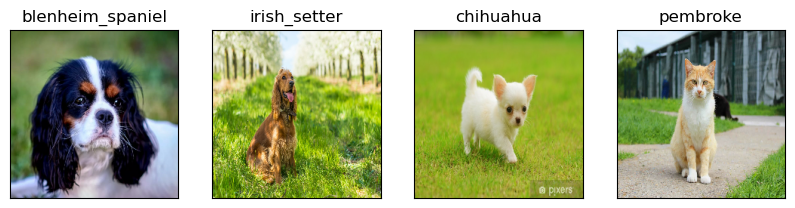

In [28]:
import matplotlib.pyplot as plt
# Check custom image prediction
plt.figure(figsize=(10,10))
for i, image in enumerate(custom_images):
  plt.subplot(1,len(custom_images),i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)